In [2]:
import sys
import os
import shutil
import unittest
from datetime import datetime
import json
import numpy as np
import fitsio
import glob
import argparse
from astropy.table import Table,join,unique,vstack
from matplotlib import pyplot as plt


In [3]:
sys.path.append(os.environ['HOME']+'/LSS/py')
from LSS import common_tools as common
from LSS.main import cattools as ct
from LSS.globals import main

256 True


In [4]:
mainp = main('LRG','loa-v1')#get settings for dark time

mt = mainp.mtld
tiles = mainp.tiles
imbits = mainp.imbits #mask bits applied to targeting
ebits = mainp.ebits #extra mask bits we think should be applied


tsnrcut = mainp.tsnrcut
dchi2 = mainp.dchi2
tnsrcol = mainp.tsnrcol        
zmin = mainp.zmin
zmax = mainp.zmax
badfib = mainp.badfib


wd = mt['SURVEY'] == 'main'
wd &= mt['ZDONE'] == 'true'
wd &= mt['FAPRGRM'] == 'dark'
wd &=mt['ZDATE'] < 20240410 #DR2


mtld = mt[wd]
ldirspec = '/global/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/'
specfo = ldirspec+'datcomb_dark_spec_zdone.fits'
specf = Table(fitsio.read(specfo.replace('global','dvs_ro')))
sel = np.isin(specf['TILEID'],mtld['TILEID'])
specf = specf[sel]


LRG


In [5]:
len(specf)

27998215

In [6]:
specf = Table(specf)
specf.keep_columns(['TARGETID','Z','ZWARN','DELTACHI2','LOCATION','DESI_TARGET','TILEID','TSNR2_LRG','TSNR2_ELG','ZWARN_MTL','COADD_FIBERSTATUS','FIBER','LASTNIGHT'])
#specf.dtype.names

In [7]:
specf = common.cut_specdat(specf,badfib=mainp.badfib_td,tsnr_min=tsnrcut,tsnr_col=tnsrcol,fibstatusbits=mainp.badfib_status,remove_badfiber_spike_nz=True,mask_petal_nights=True)

number with no data 114111
number with bad qa 730556
number at low tsnr2 487520
will mask fibers with time dependence
number removed from time dependent mask is 411848
number removed from spike mask is 56226
number removed from petal night mask is 133031


In [8]:
len(specf)

26612414

In [9]:
sel_LRG = (specf['DESI_TARGET']) & 1 > 0
sel_gz = common.goodz_infull('LRG',specf,zcol='Z')
specfl = specf[sel_LRG&sel_gz]

In [70]:
def get_repeats(indat,zcol='Z'):
    tids,cnts = np.unique(indat['TARGETID'],return_counts=True)
    rtids = tids[cnts>1]
    sel_r = np.isin(indat['TARGETID'],rtids)
    specflr = indat[sel_r]
    print(len(specflr),len(np.unique(specflr['TARGETID'])))
    specflr.sort('TARGETID')
    dzl = []
    zl1 = []
    zl2 = []
    tidl = []
    ind = 0
    while ind < len(specflr):
        tid = specflr[ind]['TARGETID']
        z1 = specflr[ind][zcol]
        ind2 = 1
        #while (ind+ind2) < len(specf_LRGr):
        while specflr[ind+ind2]['TARGETID'] == tid:
            zn = specflr[ind+ind2][zcol]
            dzl.append((z1-zn)/(1+z1))
            zl1.append(z1)
            zl2.append(zn)
            tidl.append(tid)
            ind2 += 1
            if ind+ind2 >= len(specflr):
                break
        ind += ind2
        if ind%1e4 == 0:
            print(ind)    
    res = Table()
    res['TARGETID'] = tidl
    res['Z1'] = zl1
    res['Z2'] = zl2
    return res#dzl,zl1,zl2

In [10]:
tids,cnts = np.unique(specfl['TARGETID'],return_counts=True)

In [11]:
rtids = tids[cnts>1]

In [12]:
sel_r = np.isin(specfl['TARGETID'],rtids)
specflr = specfl[sel_r]
len(specflr)

436262

In [13]:
specflr.sort('TARGETID')

In [14]:
dzl = []
zl1 = []
zl2 = []
ind = 0
while ind < len(specflr):
    tid = specflr[ind]['TARGETID']
    z1 = specflr[ind]['Z']
    ind2 = 1
    #while (ind+ind2) < len(specf_LRGr):
    while specflr[ind+ind2]['TARGETID'] == tid:
        zn = specflr[ind+ind2]['Z']
        dzl.append((z1-zn)/(1+z1))
        zl1.append(z1)
        zl2.append(zn)
        ind2 += 1
        if ind+ind2 >= len(specflr):
            break
    ind += ind2
    if ind%1e4 == 0:
        print(ind)

30000
40000
100000
110000
130000
170000
180000
210000
280000
300000
310000
330000
340000
350000
390000
400000
430000


In [15]:
len(dzl)

233471

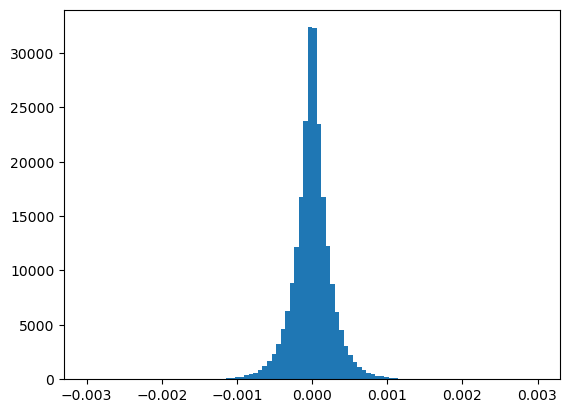

In [16]:
plt.hist(dzl,bins=100,range=(-0.003,0.003))
plt.show()

In [17]:
sel = abs(np.array(dzl)) > 0.01
np.sum(sel)/len(dzl)

0.005491045997147398

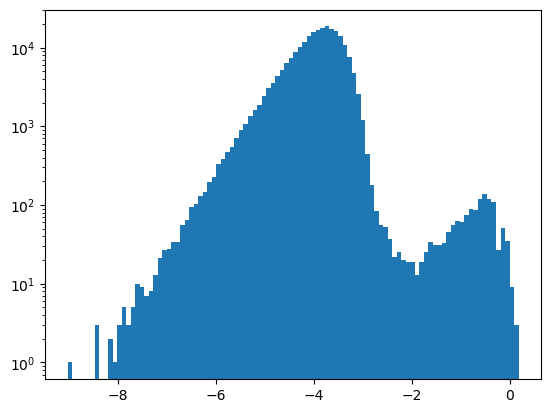

In [18]:
plt.hist(np.log10(np.abs(np.array(dzl))),bins=100)
plt.yscale('log')
plt.show()

In [20]:
qsof = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs//DA2/QSO/loa/QSO_cat_loa_cumulative_v2.fits',columns=['TARGETID','LOCATION','TILEID','Z'])

In [21]:
specf = join(specf,qsof,keys=['TARGETID','TILEID','LOCATION'],join_type='left',uniq_col_name='{col_name}{table_name}',table_names=['','_QF'])

In [23]:
specf['Z_QF'] = specf['Z_QF'].filled(999999)

In [38]:
selqso = specf['Z_QF']!=999999
selqso &= (specf['DESI_TARGET'] & 4) > 0
np.sum(selqso)

3762139

In [39]:
specfq = specf[selqso]

In [40]:
dzl,zl1,zl2 = get_repeats(specfq,zcol='Z_QF')

2103816
10000
40000
90000
100000
120000
130000
150000
180000
190000
200000
210000
220000
240000
250000
260000
270000
300000
320000
330000
340000
350000
360000
500000
530000
540000
550000
560000
580000
600000
620000
640000
700000
740000
780000
830000
840000
870000
880000
890000
920000
930000
990000
1010000
1040000
1200000
1250000
1260000
1300000
1360000
1380000
1390000
1400000
1410000
1450000
1560000
1570000
1580000
1590000
1610000
1790000
1810000
1830000
1850000
1880000
1890000
1910000
1930000
1950000
2010000
2020000
2030000
2050000
2060000
2070000
2080000


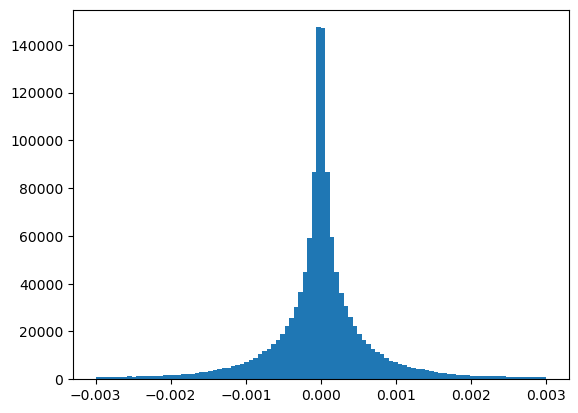

In [30]:
plt.hist(dzl,bins=100,range=(-0.003,0.003))
plt.show()

In [41]:
sel = abs(np.array(dzl)) > 0.01
np.sum(sel)/len(dzl)

0.007484592702834004

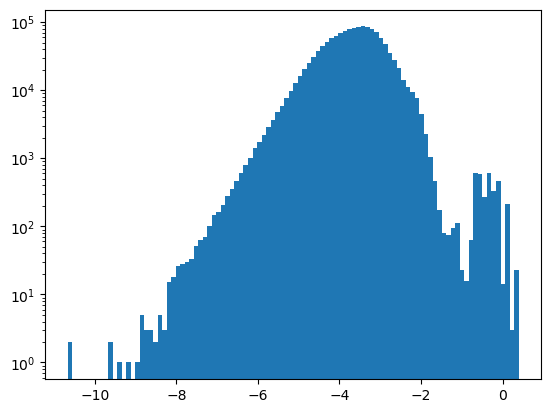

In [42]:
plt.hist(np.log10(np.abs(np.array(dzl))),bins=100)
plt.yscale('log')
plt.show()

In [43]:
selzr = np.array(zl1) < 2.1
sel = abs(np.array(dzl)[selzr]) > 0.01
np.sum(sel)/len(np.array(dzl)[selzr])

0.01025563432519107

In [44]:
elgf = fitsio.read(ldirspec+'emlin_catalog.fits',columns=['TARGETID','LOCATION','TILEID','OII_FLUX','OII_FLUX_IVAR','OIII_FLUX','OIII_FLUX_IVAR'])

In [45]:
specf = join(specf,elgf,keys=['TARGETID','TILEID','LOCATION'],join_type='left')

In [46]:
o2c = np.log10(specf['OII_FLUX'] * np.sqrt(specf['OII_FLUX_IVAR']))+0.2*np.log10(specf['DELTACHI2'])
w = (o2c*0) != 0
w |= specf['OII_FLUX'] < 0
o2c[w] = -20
specf['o2c'] = o2c


/tmp/ipykernel_1473047/205721580.py:1: RuntimeWarning: divide by zero encountered in log10
  o2c = np.log10(specf['OII_FLUX'] * np.sqrt(specf['OII_FLUX_IVAR']))+0.2*np.log10(specf['DELTACHI2'])
/tmp/ipykernel_1473047/205721580.py:1: RuntimeWarning: invalid value encountered in log10
  o2c = np.log10(specf['OII_FLUX'] * np.sqrt(specf['OII_FLUX_IVAR']))+0.2*np.log10(specf['DELTACHI2'])
/tmp/ipykernel_1473047/205721580.py:2: RuntimeWarning: invalid value encountered in multiply
  w = (o2c*0) != 0


In [47]:
sel_ELG = (specf['DESI_TARGET'] & 2) > 0
sel_gz = common.goodz_infull('ELG',specf,zcol='Z')
specfe = specf[sel_ELG&sel_gz]

In [71]:
#dzl,zl1,zl2 = get_repeats(specfe)
er = get_repeats(specfe)

1025763 476106
10000
20000
40000
50000
70000
120000
130000
160000
200000
220000
230000
240000
250000
330000
340000
370000
380000
390000
400000
440000
450000
470000
480000
500000
530000
540000
550000
560000
580000
590000
620000
640000
650000
660000
670000
700000
710000
750000
760000
790000
800000
820000
860000
870000
880000
910000
940000
950000
960000
980000


In [75]:
#sel = abs(np.array(dzl)) > 0.001
sel = abs((er['Z1']-er['Z2'])/(1+er['Z1'])) > 0.001
np.sum(sel)/len(er)

0.00264164742739563

In [54]:
selzr = np.array(zl1) > 1.49
sel = abs(np.array(dzl)[selzr]) > 0.001
np.sum(sel)/len(np.array(dzl)[selzr])

0.006958021851638873

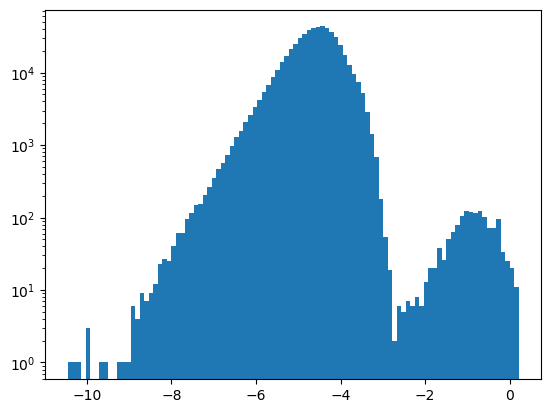

In [52]:
plt.hist(np.log10(np.abs(np.array(dzl))),bins=100)
plt.yscale('log')
plt.show()

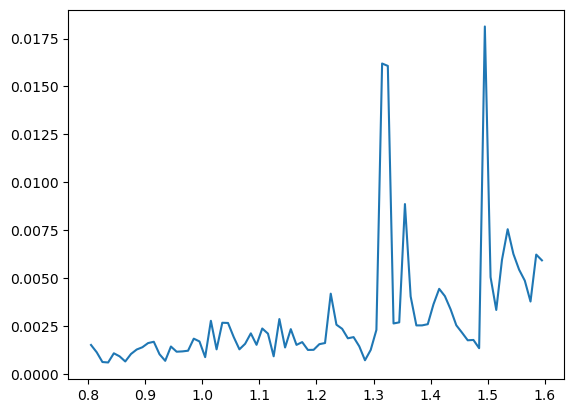

In [59]:
zm = 0.8
zl = []
cfl = []
while zm < 1.6:
    selzr = np.array(zl1) > zm
    selzr &= np.array(zl1) < zm+.01
    sel = abs(np.array(dzl)[selzr]) > 0.001
    zl.append(zm+.005)
    cfl.append(np.sum(sel)/len(np.array(dzl)[selzr]))
    #print(zm,)
    zm += .01
plt.plot(zl,cfl)

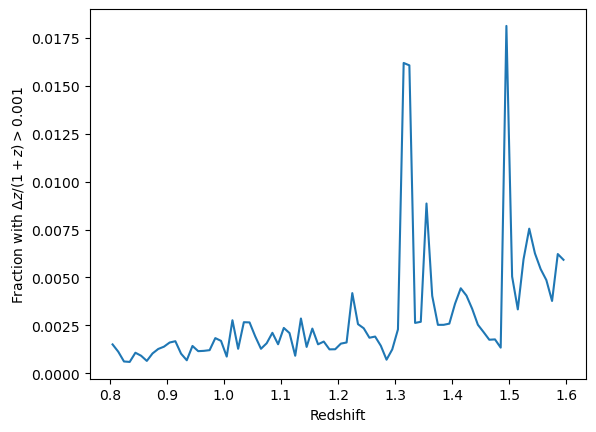

In [61]:
plt.plot(zl,cfl)
plt.xlabel('Redshift')
plt.ylabel(r'Fraction with $\Delta z/(1+z)>0.001$')
plt.show()

In [62]:
os.getenv('SCRATCH')

'/pscratch/sd/a/ajross'

In [63]:
len(dzl)

549657

In [77]:
bgsr = fitsio.read(ldirspec+'BGSrepeats.fits')

In [78]:
len(bgsr)

465089

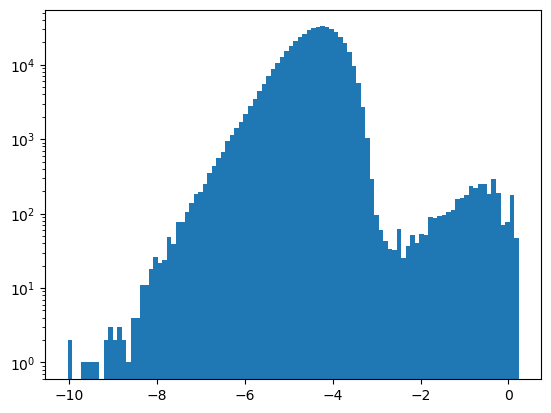

In [79]:
dzl = (bgsr['Z1']-bgsr['Z2'])/(1+bgsr['Z1'])
plt.hist(np.log10(np.abs(np.array(dzl))),bins=100)
plt.yscale('log')
plt.show()